In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib import dates as mpl_dates
import os
pd.options.mode.copy_on_write = True

In [3]:
#Reading in raw data
Purchase_Orders = pd.read_csv(r'C:\Users\PurchaseOrders.csv')
Purchase_Order_Lines = pd.read_csv(r'C:\Users\PurchaseOrderLines.csv')

In [4]:
#Combining datasets to find orders by date
Orders_by_date = Purchase_Order_Lines.merge(Purchase_Orders,how='left',on='PurchaseOrderID')

In [5]:
#Selecting useful columns for analysis - Order date and quantity of orders
Orders_by_date2 = Orders_by_date[['OrderedOuters','OrderDate']]
print(Orders_by_date2.head(5))

   OrderedOuters   OrderDate
0             18  2013-01-01
1             21  2013-01-01
2             18  2013-01-01
3              8  2013-01-01
4              1  2013-01-01


In [6]:
#Summarising sales by month
Orders_by_date2['OrderDate'] = pd.to_datetime(Orders_by_date2['OrderDate'])
Orders_by_date2['OrderMonth'] = Orders_by_date2['OrderDate'].dt.floor('d')+pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1)
Order_data = Orders_by_date2.groupby(['OrderMonth'])['OrderedOuters'].sum()

print(Order_data.head(5))

OrderMonth
2013-01-01     8178
2013-02-01     7693
2013-03-01    14552
2013-04-01    25963
2013-05-01    40298
Name: OrderedOuters, dtype: int64


<Axes: title={'center': 'Dataframe plot'}, xlabel='OrderMonth'>

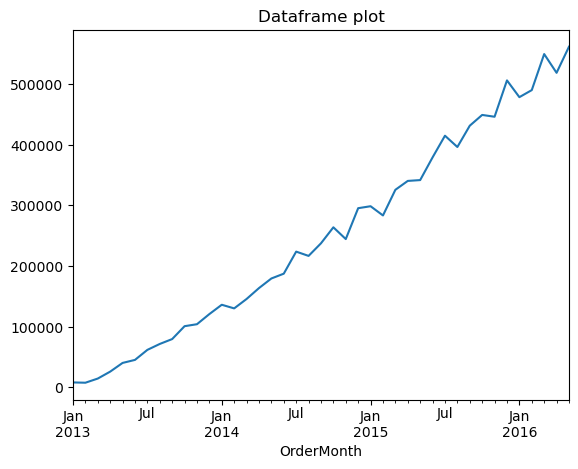

In [7]:
#Plotting the resultant 1d series
Order_data.plot(title = "Dataframe plot")

In [8]:
#We will carry out tests on a smaller subset of the data, acheived by filtering "order data"
startdate = pd.to_datetime("2013-01-01")
enddate = pd.to_datetime("2015-12-31")

In [9]:
#Filtering "order data" based on the dates set above
Train_data = Order_data[(Order_data.index>=startdate)&(Order_data.index<=enddate)]
print(Test_data.tail(5))

NameError: name 'Test_data' is not defined

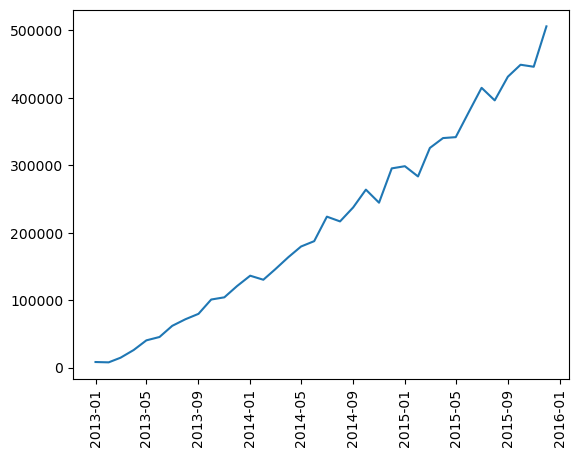

In [10]:
x = Train_data.index
plt.xticks(rotation=90)
plt.plot(Train_data)

In [11]:
#Carrying out statistical tests to check suitability of data for forecasting
RollingMean=Train_data.rolling(window=12).mean()
Rollingstd=Train_data.rolling(window=12).std()

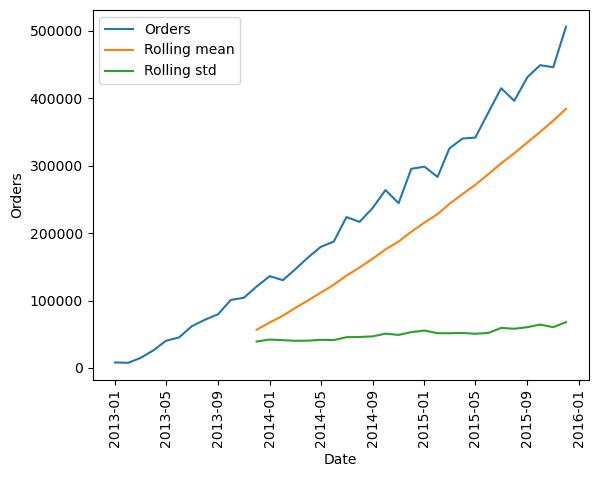

In [12]:
#Plotting rolling figures against orders data
plt.plot(Train_data,label='Orders')
plt.plot(RollingMean,label='Rolling mean')
plt.plot(Rollingstd,label='Rolling std')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Orders')
plt.xticks(rotation=90)
plt.show()

From the above we can see that the rolling mean and standard deviations are not constant. Therefore, the data is not stationary, and cannot be used for forecasting in its present form.

In [13]:
from statsmodels.tsa.stattools import adfuller

dftest=adfuller(Train_data,autolag = 'AIC')
dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','Number of observations used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key]=value
    
    print(dfoutput)

Test Statistic                  3.587773
p-value                         1.000000
#lags used                     10.000000
Number of observations used    25.000000
Critical Value (1%)            -3.723863
dtype: float64
Test Statistic                  3.587773
p-value                         1.000000
#lags used                     10.000000
Number of observations used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
dtype: float64
Test Statistic                  3.587773
p-value                         1.000000
#lags used                     10.000000
Number of observations used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64


As the test statistic is larger than the critical value, this shows the data is not stationary

float64


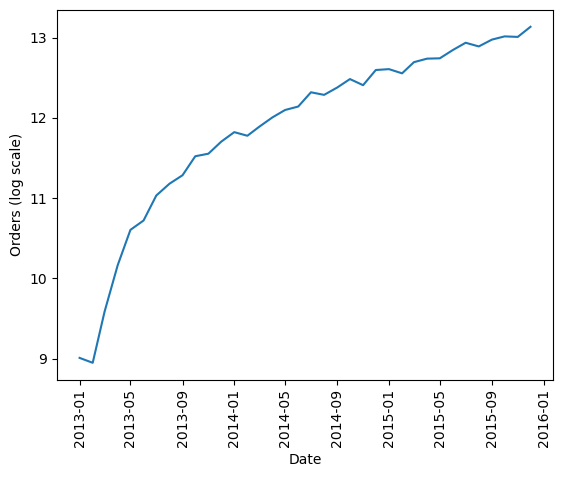

In [15]:
Train_data_logscale = np.log(Train_data)
Train_data_logscale = Train_data_logscale.astype(float)
print(Train_data_logscale.dtype)
gr_log = plt.plot(Train_data_logscale)
plt.xlabel('Date')
plt.ylabel('Orders (log scale)') 
plt.xticks(rotation=90)
  
plt.show()    

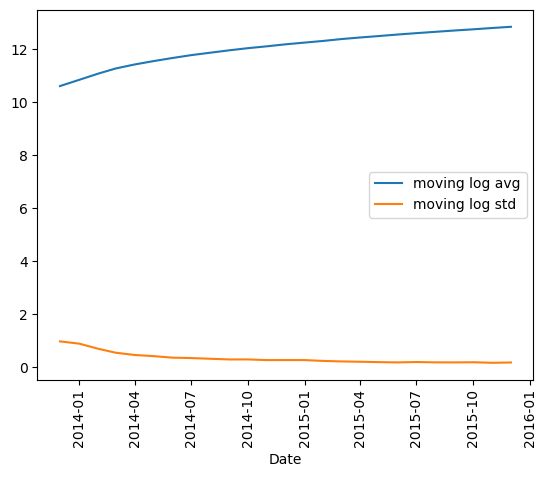

In [24]:
Moving_log_avg = Train_data_logscale.rolling(window=12).mean()
Moving_log_std = Train_data_logscale.rolling(window=12).std()
plt.plot(Moving_log_avg,label='moving log avg')
plt.plot(Moving_log_std,label='moving log std')
plt.xlabel('Date')
plt.legend()
plt.xticks(rotation=90)
plt.show()

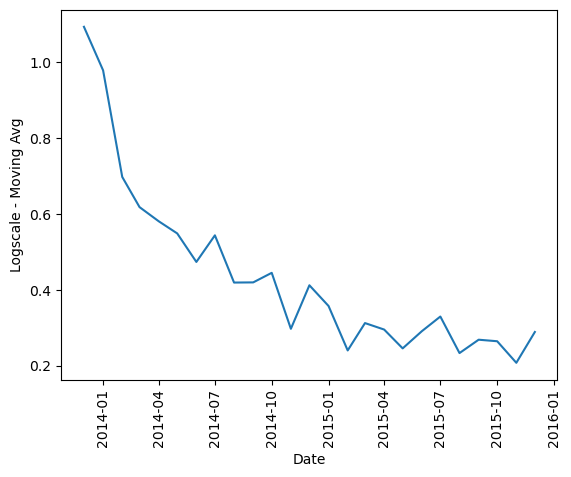

In [33]:
logscale_minus_Moving_log_avg = Train_data_logscale - Moving_log_avg
plt.plot(Train_data_logscale_minus_Moving_log_avg)
plt.xlabel('Date')
plt.ylabel('Logscale - Moving Avg')
plt.xticks(rotation=90)

logscale_minus_Moving_log_avg.dropna(inplace=True)

plt.show()

In [34]:
def test_4_stationarity(timeseries):
    #plot rolling statistics
    movinglogavg=timeseries.rolling(window=6).mean()
    movinglogstd=timeseries.rolling(window=6).std()
    
    #plotting original data
    orig=plt.plot(timeseries, color = 'blue', label = 'Original')
    #plot mean
    mean=plt.plot(movinglogavg, color='red', label='mean')
    #plot std
    std=plt.plot(movinglogstd, color ='green', label='std')
    plt.xticks(rotation=90)
    
    plt.legend(loc='best')
    plt.show(block=False)
    
  #perform dickey-fuller test
    print('results of Dickey-Fuller test')
    dftest=adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','#lags used','Number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)'%key]=value
    print(dfoutput)

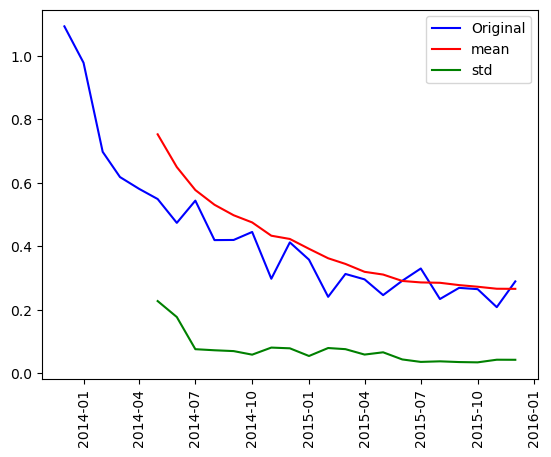

results of Dickey-Fuller test
Test Statistic                 -4.812850
p-value                         0.000051
#lags used                      2.000000
Number of observations used    22.000000
Critical value (1%)            -3.769733
Critical value (5%)            -3.005426
Critical value (10%)           -2.642501
dtype: float64


In [35]:
test_4_stationarity(logscale_minus_Moving_log_avg)

The critical value is larger than the test statistic therefore carrying out this data transformation causes the data to be stationary

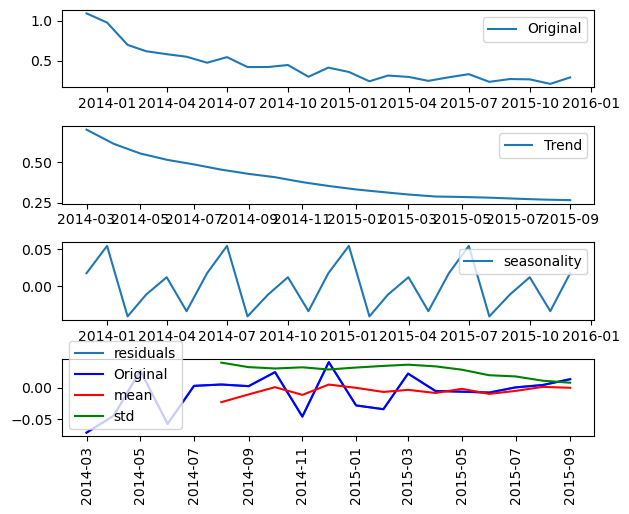

results of Dickey-Fuller test
Test Statistic                 -5.582642
p-value                         0.000001
#lags used                      1.000000
Number of observations used    17.000000
Critical value (1%)            -3.889266
Critical value (5%)            -3.054358
Critical value (10%)           -2.666984
dtype: float64


In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(logscale_minus_Moving_log_avg,model='additive', period=6)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


residual = residual.astype(float)

plt.subplot(411)
plt.plot(logscale_minus_Moving_log_avg,label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='residuals')
plt.legend(loc='best')
plt.tight_layout()



decomposedlogdata=residual
decomposedlogdata.dropna(inplace=True)
test_4_stationarity(decomposedlogdata)





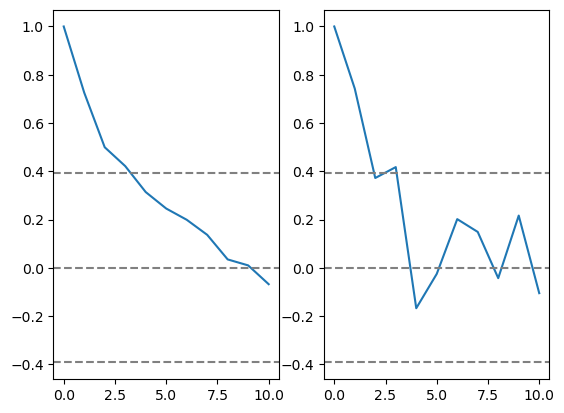

In [40]:
#ACF and PACF plots

from statsmodels.tsa.stattools import acf,pacf

lag_acf = acf(logscale_minus_Moving_log_avg, nlags=10)
lag_pacf = pacf(logscale_minus_Moving_log_avg,nlags=10, method='ols')

#plot acf
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle = '--', color = 'gray')
plt.axhline(y=-1.96/np.sqrt(len(logscale_minus_Moving_log_avg)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(logscale_minus_Moving_log_avg)), linestyle='--', color='gray')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle = '--', color = 'gray')
plt.axhline(y=-1.96/np.sqrt(len(logscale_minus_Moving_log_avg)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(logscale_minus_Moving_log_avg)), linestyle='--', color='gray')
plt.show()

C:\Users\josh2\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\josh2\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\josh2\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Plotting AR model


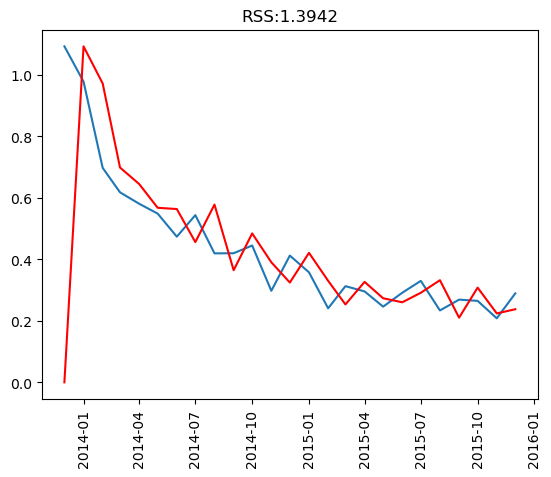

OrderMonth
2013-12-01    1.195127
2014-01-01    0.013159
2014-02-01    0.075374
2014-03-01    0.006516
2014-04-01    0.004134
dtype: float64

In [49]:
from statsmodels.tsa.arima.model import ARIMA

model=ARIMA(logscale_minus_Moving_log_avg, order=(1,1,2))
results_AR = model.fit()
plt.xticks(rotation=90)
plt.plot(logscale_minus_Moving_log_avg)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS:%.4f'% sum((results_AR.fittedvalues-logscale_minus_Moving_log_avg)**2))
print('Plotting AR model')
plt.show()
(results_AR.fittedvalues.head()-logscale_minus_Moving_log_avg.head())**2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


OrderMonth
2013-12-01    0.000000
2014-01-01    1.093219
2014-02-01    0.972363
2014-03-01    0.699053
2014-04-01    0.645420
dtype: float64
OrderMonth
2013-12-01    0.000000
2014-01-01    1.093219
2014-02-01    2.065582
2014-03-01    2.764635
2014-04-01    3.410054
dtype: float64


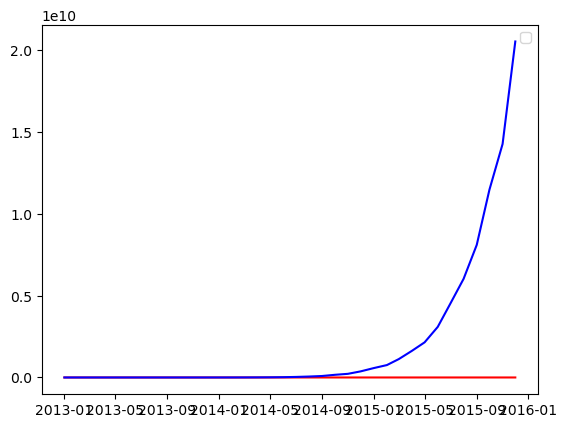

AttributeError: 'ARIMAResults' object has no attribute 'plot_predict'

In [55]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

predictions_ARIMA_log = pd.Series(Train_data_logscale,index = Train_data_logscale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(Train_data,color='red')
plt.plot(predictions_ARIMA,color='blue')
plt.legend(loc='best')
plt.show()

results_AR.plot_predict(1,264)
x=results.ARIMA.forecast(steps=36)
print(x)